In [1]:
%run ../data_preparation.ipynb

Number of finding labels: 16297
Complete


In [2]:
# Splitting data into training and validation sets.
from sklearn.model_selection import train_test_split
training_df, validation_df = train_test_split(xray_labels_df, 
                                              test_size = 0.25, 
                                              random_state = 2018,
                                              stratify = xray_labels_df['Finding Labels'].map(lambda x: x[:4]))

print('train', training_df.shape[0], 'validation', validation_df.shape[0])

train 9000 validation 3000


In [3]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip=True,
                              vertical_flip=True,
                              height_shift_range=0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)

C:\Users\AJ\Anaconda3\envs\csc665\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Generates training and validation data to be used by models.
# Lowered batch size so that we can run this on a GPU.
training_gen = flow_from_dataframe(core_idg, training_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 16)
validation_gen = flow_from_dataframe(core_idg, validation_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 128)

test_X, test_Y = next(flow_from_dataframe(core_idg, validation_df, path_col ='path', y_col ='disease_vec', target_size = IMG_SIZE, color_mode = 'grayscale', batch_size = 1024))



Found 0 images belonging to 0 classes.
Reinserting dataframe: 9000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3000 images


In [5]:
t_x, t_y = next(training_gen)

In [6]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

base_mobilenet_model = MobileNet(input_shape = t_x.shape[1:],
                                 include_top = False, weights = None)

multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss ='binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_256 (Model)   (None, 8, 8, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 3,756,679
Trainable params: 3,734,791
Non-trainable params: 21,888
_____________________________________________________________

In [22]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights_sigmoid_256x256.best.hdf5".format("xray_class")

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10)
callbacks_list = [checkpoint, early]

In [18]:
multi_disease_model.fit_generator(training_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 106s 1s/step - loss: 0.4147 - binary_accuracy: 0.8838 - mean_absolute_error: 0.1535 - val_loss: 0.8000 - val_binary_accuracy: 0.7762 - val_mean_absolute_error: 0.2311

Epoch 00001: val_loss improved from inf to 0.80003, saving model to xray_class_weights_sigmoid_256x256.best.hdf5


In [19]:
multi_disease_model.load_weights(weight_path)

In [20]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

512/512 [==============================] - 3s 6ms/step


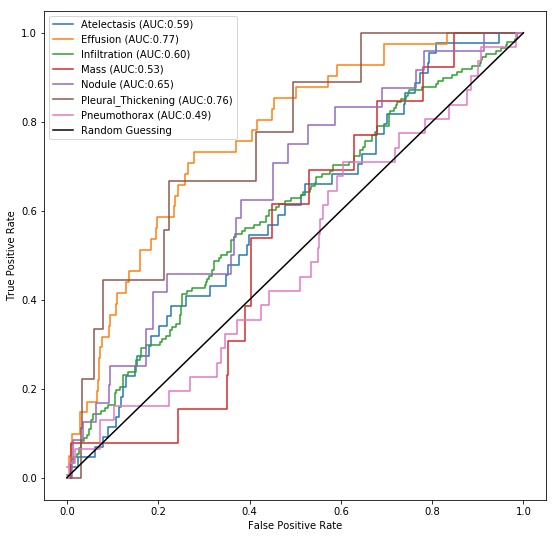

In [40]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net_sigmoid_256x256.png')

In [23]:
history = multi_disease_model.fit_generator(training_gen, 
                                            steps_per_epoch = 100,
                                            validation_data =  (test_X, test_Y), 
                                            epochs = 100, 
                                            callbacks = callbacks_list)

Epoch 1/100
100/100 [==============================] - 111s 1s/step - loss: 0.3399 - binary_accuracy: 0.8934 - mean_absolute_error: 0.1555 - val_loss: 0.2716 - val_binary_accuracy: 0.9090 - val_mean_absolute_error: 0.1323

Epoch 00001: val_loss improved from inf to 0.27158, saving model to xray_class_weights_sigmoid_256x256.best.hdf5
Epoch 2/100
100/100 [==============================] - 109s 1s/step - loss: 0.3027 - binary_accuracy: 0.9015 - mean_absolute_error: 0.1576 - val_loss: 0.3131 - val_binary_accuracy: 0.9004 - val_mean_absolute_error: 0.1532

Epoch 00002: val_loss did not improve
Epoch 3/100
100/100 [==============================] - 105s 1s/step - loss: 0.2833 - binary_accuracy: 0.9050 - mean_absolute_error: 0.1515 - val_loss: 0.2862 - val_binary_accuracy: 0.9135 - val_mean_absolute_error: 0.1076

Epoch 00003: val_loss did not improve
Epoch 4/100
100/100 [==============================] - 102s 1s/step - loss: 0.2869 - binary_accuracy: 0.9084 - mean_absolute_error: 0.1529 - v

In [7]:
multi_disease_model.load_weights('xray_class_weights_sigmoid_256x256.best.hdf5')
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 10s 9ms/step


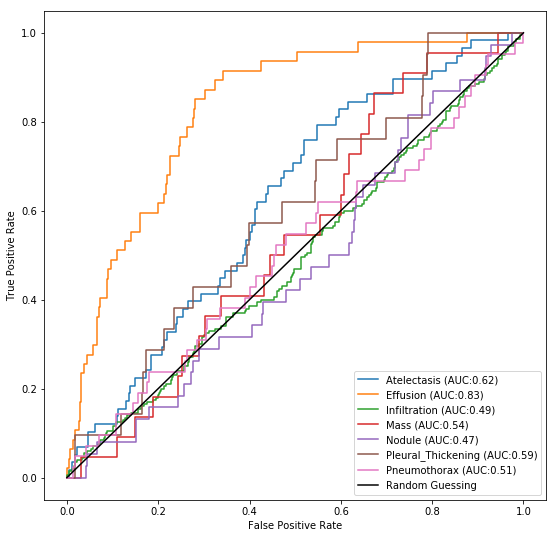

In [14]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('roc_31epochs_sigmoid_256x256.png')

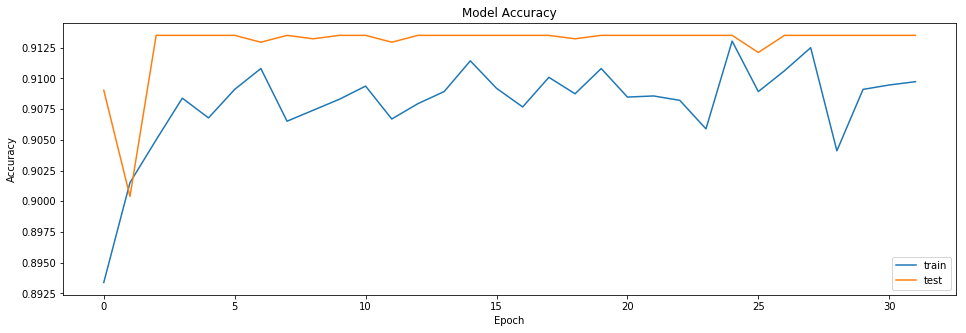

In [37]:
plt.figure(1, figsize = (16,5))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

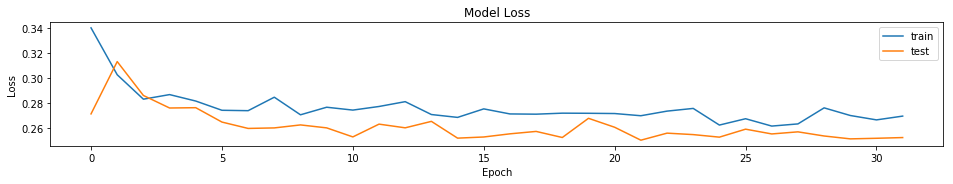

In [36]:
plt.figure(1, figsize = (16,5))
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')

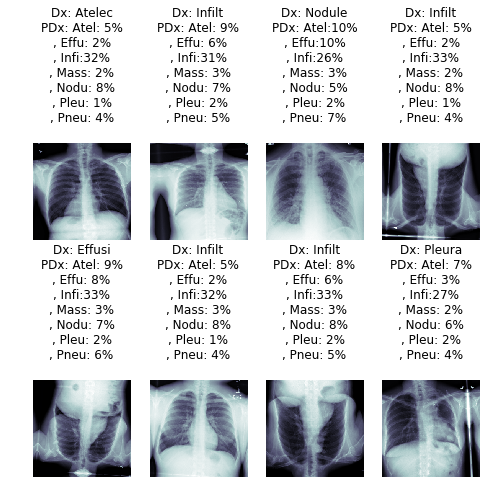

In [8]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(2, 4, figsize = (8, 8))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    
    pred_str = ['%s:%2.0f%%\n' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) ]
    
    
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions_256x256_basic_model.png')